# Example of an EoR0 sky simulation using OSKAR

In this example we take an arbitrary sky and use karabo to simulate the visibilities. We simulate the visibilites once using OSKAR and once using RASCIL. For the imaging we use RASCIL in both cases. We also show the usage of primary beams in karabo.

In [25]:
import math
import os
import shutil
from datetime import datetime, timedelta, timezone
import numpy as np

# these have to go before importing karabo
os.environ["TMPDIR"] = "/cygnus/tmp"
%env TMPDIR=/cygnus/tmp

from karabo.data.obscore import ObsCoreMeta
from karabo.data.src import RucioMeta
from karabo.imaging.image import Image
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
)
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.telescope_versions import SKALowAAStarVersions, SKALowAA1Versions
from karabo.simulation.visibility import Visibility
from karabo.simulator_backend import SimulatorBackend
from karabo.util.helpers import get_rnd_str


# Simulation
# Phase center: should be mean of coverage
# Means of values from sky model description
PHASE_CENTER_RA = 20.0
PHASE_CENTER_DEC = -27.0

# Imaging
IMAGING_NPIXEL = 8000
IMAGING_CELLSIZE = 0.00006 # can't tell if radians or degrees

# Metadata
NAME_PREFIX = "skalow_eor_"

# Output root dir, this is just a default, set to your liking
OUTPUT_ROOT_DIR = os.path.join("/cygnus", f"{NAME_PREFIX}output")
os.makedirs(OUTPUT_ROOT_DIR, exist_ok=True)
print(f"Output will be written under output root dir {OUTPUT_ROOT_DIR}")

# 1 timestep, 375 channels starting from 170 MHz to 200 MHz, 80kHz wide
# Wavelength 185MHz = 1.62 m
number_of_time_steps = 1
start_frequency_hz = 170e6
end_frequency_hz = 200e6
frequency_increment_hz = 80e3
number_of_channels = math.floor(
    (end_frequency_hz - start_frequency_hz) / frequency_increment_hz
)

os.environ["TMPDIR"] = "/cygnus/tmp"

%matplotlib inline
%env TMPDIR=/cygnus/tmp

env: TMPDIR=/cygnus/tmp
Output will be written under output root dir /cygnus/skalow_eor_output
env: TMPDIR=/cygnus/tmp


## Sky Model : GLEAM

num_sources=1
right ascension (deg),declination (deg),stokes I Flux (Jy),stokes Q Flux (Jy),stokes U Flux (Jy),stokes V Flux (Jy),reference_frequency (Hz),spectral index (N/A),rotation measure (rad / m^2),major axis FWHM (arcsec),minor axis FWHM (arcsec),position angle (deg),true redshift,observed redshift,source id (object)
20.0,-27.0,100.0,0.0,0.0,0.0,150000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


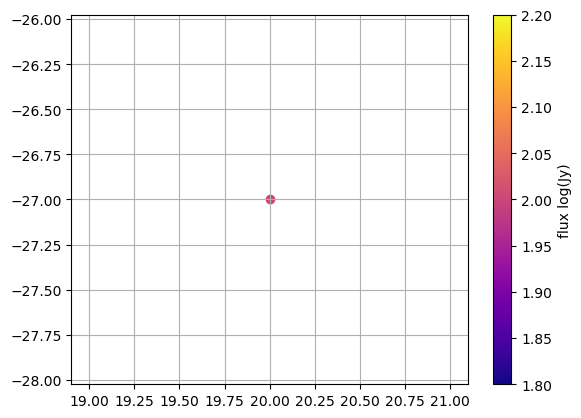

In [26]:
sky_model = SkyModel()
sky_model.add_point_sources(np.array([[
    PHASE_CENTER_RA, # RA
    PHASE_CENTER_DEC, # Dec
    100.0, # stokes I Flux (Jy),
    0.0, # stokes Q Flux (Jy),
    0.0, # stokes U Flux (Jy),
    0.0, # stokes V Flux (Jy),
    150e6, # reference_frequency (Hz),
    0.0, # spectral index (N/A),
    0.0, # rotation measure (rad / m^2),
    0.0, # major axis FWHM (arcsec),
    0.0, # minor axis FWHM (arcsec),
    0.0, # position angle (deg),
    0.0, # true redshift,
    0.0, # observed redshift,
    0, # source id (object)
]]))
# sky_model = SkyModel.get_GLEAM_Sky(min_freq=start_frequency_hz, max_freq=end_frequency_hz)\
#     .filter_by_flux(min_flux_jy=0.005, max_flux_jy=100000)\
#     .filter_by_radius(ra0_deg=PHASE_CENTER_RA, dec0_deg=PHASE_CENTER_DEC, inner_radius_deg=0, outer_radius_deg=90)

print(f"num_sources={len(sky_model.sources)}")
sky_model.save_sky_model_as_csv('/dev/stdout')

sky_model.explore_sky(
    phase_center=(PHASE_CENTER_RA, PHASE_CENTER_DEC),
    wcs_enabled=False,
)

limited sourcelist filtering.
would be nice to filter by beam used in InterferometerSimulation (next section)

## Telescope Model SKA Low AAstar

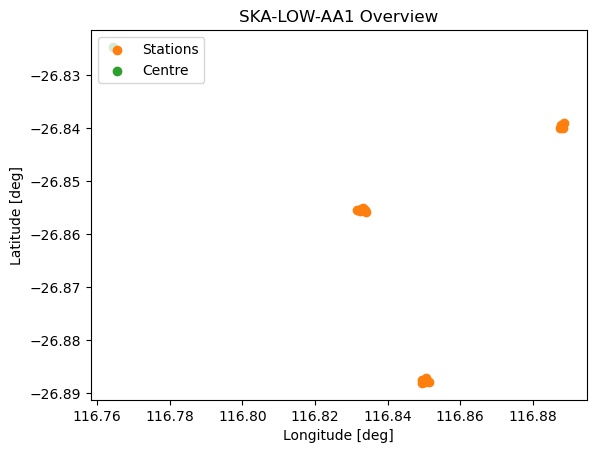

In [ ]:
simulator_backend = SimulatorBackend.OSKAR

telescope = Telescope.constructor(  # type: ignore[call-overload]
    name="SKA-LOW-AAstar",
    version=SKALowAAStarVersions.SKA_OST_ARRAY_CONFIG_2_3_1,
    backend=simulator_backend,
)

telescope.plot_telescope()

## Run Simulation

In [ ]:

simulation = InterferometerSimulation(
    channel_bandwidth_hz=frequency_increment_hz,
    station_type="Aperture array",
    use_gpus=True,
)

observation = Observation(
    phase_centre_ra_deg=PHASE_CENTER_RA,
    phase_centre_dec_deg=PHASE_CENTER_DEC,
    start_date_and_time=datetime(2000, 1, 1, 5, 30, 0, 0, timezone.utc),
    length=timedelta(seconds=number_of_time_steps * 7.997),
    number_of_time_steps=number_of_time_steps,
    number_of_channels=number_of_channels,
    start_frequency_hz=start_frequency_hz,
    frequency_increment_hz=frequency_increment_hz,
)

sim_start = datetime.now()
print(f"{sim_start} starting simulation number_of_channels={number_of_channels} number_of_time_steps={number_of_time_steps}")

vis_out_path = os.path.join(
    OUTPUT_ROOT_DIR,
    f"{NAME_PREFIX}.MS",
)
# delete existing visibility file if it exists
if os.path.exists(vis_out_path):
    # it's a directory
    shutil.rmtree(vis_out_path)

visibilities = simulation.run_simulation(  # type: ignore[no-any-return]
    telescope,
    sky_model,
    observation,
    backend=simulator_backend,
    visibility_path=vis_out_path,
)  # type: ignore[call-overload]

sim_end = datetime.now()
print(f"{sim_end} simulation completed: {sim_end - sim_start}")

2025-08-14 09:19:57.564973 starting simulation number_of_channels=375 number_of_time_steps=1
Matched path /cygnus/skalow_eor_output/skalow_eor_.MS to format MS
Saved visibility to /cygnus/skalow_eor_output/skalow_eor_.MS
2025-08-14 09:19:58.468063 simulation completed: 0:00:00.903090


## Metadata

In [ ]:
ocm = ObsCoreMeta.from_visibility(
    vis=visibilities,
    calibrated=False,
)
print(ocm)

skipping tbrow=0
skipping tbrow=1
skipping tbrow=2
skipping tbrow=3
skipping tbrow=4
skipping tbrow=5
skipping tbrow=6
skipping tbrow=7
skipping tbrow=8
skipping tbrow=9
skipping tbrow=10
skipping tbrow=11
skipping tbrow=12
skipping tbrow=13
skipping tbrow=14
skipping tbrow=15
skipping tbrow=16
skipping tbrow=17
skipping tbrow=18
skipping tbrow=19
skipping tbrow=20
skipping tbrow=21
skipping tbrow=22
skipping tbrow=23
skipping tbrow=24
skipping tbrow=25
skipping tbrow=26
skipping tbrow=27
skipping tbrow=28
skipping tbrow=29
skipping tbrow=30
skipping tbrow=31
skipping tbrow=32
skipping tbrow=33
skipping tbrow=34
skipping tbrow=35
skipping tbrow=36
skipping tbrow=37
skipping tbrow=38
skipping tbrow=39
skipping tbrow=40
skipping tbrow=41
skipping tbrow=42
skipping tbrow=43
skipping tbrow=44
skipping tbrow=45
skipping tbrow=46
skipping tbrow=47
skipping tbrow=48
skipping tbrow=49
skipping tbrow=50
skipping tbrow=51
skipping tbrow=52
skipping tbrow=53
skipping tbrow=54
skipping tbrow=55
sk

Mean of empty slice.
invalid value encountered in scalar divide


## Imaging

Creating /cygnus/tmp/karabo-STM-dev-SGvXP4bT71/WSClean-dirty-UQv3Hx0HO6 for Disk cache for WSClean dirty images
WSClean command: [cd /cygnus/tmp/karabo-STM-dev-SGvXP4bT71/WSClean-dirty-UQv3Hx0HO6 && OPENBLAS_NUM_THREADS=1 wsclean -size 8000 8000 -scale 0.0034377467707849396deg /cygnus/skalow_eor_output/skalow_eor_.MS]


WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  170-200 (375)
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening /cygnus/skalow_eor_output/skalow_eor_.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-120; 120 rows)
Detected 503.7 GB of system memory, usage not limited.
Opening /cygnus/skalow_eor_output/skalow_eor_.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-120; 120 rows)
Determining min and max w & theoretical beam size... DONE (w=[2.09352:3646.34] lambdas, maxuvw=3869.46 lambda)
Theoretic beam = 53.31''
Minimal inversion size: 4458 x 4458, using optimal: 4480 x 4480
Loading data in memory.

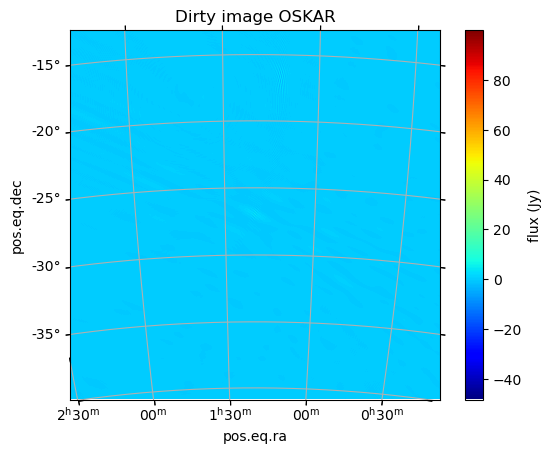

In [ ]:
dirty_imager = WscleanDirtyImager(
    DirtyImagerConfig(
        imaging_npixel=IMAGING_NPIXEL,
        imaging_cellsize=IMAGING_CELLSIZE,
        combine_across_frequencies=True,
    )
)

dirty_image = dirty_imager.create_dirty_image(
    visibilities,
    output_fits_path=os.path.join(
        OUTPUT_ROOT_DIR,
        f"{NAME_PREFIX}dirty.fits",
    ),
)

dirty_image.plot(
    title="Dirty image OSKAR",
    # vmin=0, vmax=1.0
)


In [ ]:
image_cleaner = WscleanImageCleaner(
    WscleanImageCleanerConfig(
        imaging_npixel=IMAGING_NPIXEL,
        imaging_cellsize=IMAGING_CELLSIZE,
    )
)

clean_image = image_cleaner.create_cleaned_image(
    visibilities,
    # dirty_fits_path=dirty_image.path,
    output_fits_path=os.path.join(
        OUTPUT_ROOT_DIR,
        f"{NAME_PREFIX}cleaned.fits",
    ),
)

clean_image.plot(
    title="Clean image OSKAR + WSClean",
    # vmin=0, vmax=1.0
)

Creating /cygnus/tmp/karabo-STM-dev-SGvXP4bT71/WSClean-cleaned-3UeeXcH6TR for Disk cache for WSClean cleaned images
WSClean command: [cd /cygnus/tmp/karabo-STM-dev-SGvXP4bT71/WSClean-cleaned-3UeeXcH6TR && OPENBLAS_NUM_THREADS=1 wsclean -size 8000 8000 -scale 0.0034377467707849396deg -niter 50000 -mgain 0.8 -auto-threshold 3 /cygnus/skalow_eor_output/skalow_eor_.MS]
